<a href="https://colab.research.google.com/github/Rompil/hands-on/blob/master/PySpark_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache-mirror.rbc.ru/pub/apache/spark/spark-2.4.1/spark-2.4.1-bin-hadoop2.7.tgz
!tar xvzf spark-2.4.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.1-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
#sc = SparkContext(appName='MLlibHands_on')

In [0]:
!wget http://devdemo.competentum.com/dataset/boston_train.csv


# Обзор модуля PySpark MLlib


Модуль MLlib предназначен для использования уже готовых алгоритмов машинного обучения в прикладных задачах при обработке больших данных. Во многом он схож с Scikit-learn, что делает его легким в освоении и позволяет переносить уже готовые методы обработки данных на платформу Spark.

Для лучшего понимания того, зачем делать определенные этапы потом, мы обсудим задачу машинного обучения  в первом приближении.

Вне зависимости от конкретного выбранного алгоритма анализа данных можно выделить схожие этапы:


*   Загрузка и отчистка данных.
*   Извлечение признаков (фич)
*   Тренировка модели
*   Оценка целевых показателей

Эти этапы могут повторяться неоднократно в процессе настройки гиперпараметров модели.

В Spark такой подход унифицировали и сосокупность таких этапов упаковали в **Pipeline**.
Каждый этап в Pipeline представляет из себя либо Transformer, либо Estimator, либо Evaluator.
При этом, Pipeline может содержать произвольное количество таких унафицированных этапов, каждый из которых может быть соединен с другим и выступать как източником , так и потребителем для других этапов.
Каждый из таких этапов надо рассмотреть подробнее.





**Transformer:** 


*   Используется на этапе препроцессинга
*   Преобразует данные в необходимый формат для далдьнейшей обработки
*   Обрабатывает по столбцам столбец на входе -> столбец на выходе

Примеры Transformers:
          

*   Нормализация - приведение значений к диапазону от 0 до 1 или к стандартному распределению.
*   Токенизация - замена слов числами
*   Замена категориальных признаков на числовые

Обычно такогого рода преоразования вызывают метод .transform(), на входе и на выходе dataframe.







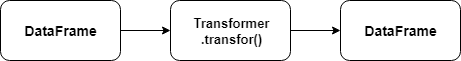

**Estimator:**


*   Чаще всего это обучающие алгоритмы, которые тренеруются на данных
*   Возвращают на выходе модель алгоритма, у которой можно вызвать .transform(), т.е. transformer

Пример Estimator:

>LogisticRegresion.fit(...)  $\longrightarrow$ LogisticRegressionModel.transform()



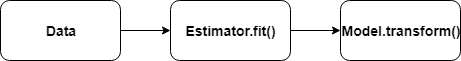

**Evaluator:**



*   Оценивает качество модели на основе определенных параметров: ROC, RMSE
*   Учавствует в автоматическом тюнинге гиперпараметров модели 
*   Позволяет сравнивать качество моделей и выбрать лучшие

Пример Evaluator:

> BinaryClassificationEvaluator

>CrossValidator





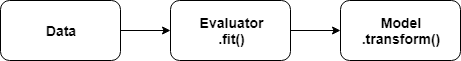

В совокупности такие этапы работы с данными и формируют **Pipeline**

Pipeline  

*   Используется для представления потока обработки данных в ML   
*   Состоит из отдельных этапов, которае легко контроллировать.
*   Эти этапы унифицированы и легко взаимозаменяемы.
*   Сам Pipeline является экземпляром типа Estimator и для него модно вызвать метод .fit()
*   Pipeline можно как сохранить во внешней памяти, так  и загрузить из нее для повторного использования.



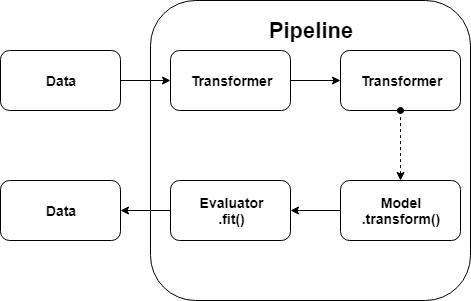

##Основные модули MLlib

Если разбираться в MLlib детальнее, то можно выделить отдельные группы подмодулей, каждый из которых предназначен для решения своего рода задач:


*   ML Algorithms - Все основные распространенные алгоритмы машинного обучения которые встречаются на практике: линейная регрессия, логистическая регрессия, клатеризация и т.д.
*   Featurization - Методы преобразования и извлечения признаков, уменьшения размерности и формирования выборки. 
*   Pipelines - инструменты формирования, оценивания и настройки (тюнинга) ML Pipeline'ов
*   Persistance - средства сохранения и загрузки алгоритмов, моделей и целых Pipeline'ов
*   Utilities - Все необходимое, связанное с линейной алгеброй, статистикой и вероятностью.



Перед тем как непосредственно начать работать с MLlib надо познакомиться с основными типами данных, с которыми придется иметь дело в примерах.



**Vector**

Векторы в Spark могут задаваться двумя способами:


*   "Плотный" (Dense) вектор, элементы которого задаются перечислением. Совместим с array из  numpy.
*   "Разряженный" (Sparse) вектор, значения в нем задаются по индексу.




In [0]:
from numpy import array
from pyspark.mllib.linalg import Vectors

denseVec1 = array([1.0, 2.0, 3.0])
denseVec2 = Vectors.dense([1.0, 2.0, 3.0])

sparseVec1 = Vectors.sparse(4, {0:1.0, 2:2.0})
sparseVec2 = Vectors.sparse(4, [0, 2], [1.0, 2.0])

**LabeledPoint**

Размеченная точка используется часто для представления данных  в training set'ах как единичный сэмпл. Состоит из label и features.

In [5]:
from pyspark.mllib.regression import LabeledPoint
my_point = LabeledPoint(1.0, denseVec1)
print(my_point.label, my_point.features)

1.0 [1.0,2.0,3.0]


Естественно, что имея массивы с числовыми данными, мы можем производить различные манипуляции для выявления зависимостей.

Например, посчитать коэффициенты корреляции для 4 векторов. 

In [16]:

from pyspark.ml.stat import Correlation

data = [(Vectors.sparse(4, [(0, 1.0), (3, -2.0)]),),
        (Vectors.dense([4.0, 5.0, 0.0, 3.0]),),
        (Vectors.dense([6.0, 7.0, 0.0, 8.0]),),
        (Vectors.sparse(4, [(0, 9.0), (3, 1.0)]),)]
df = spark.createDataFrame(data, ["features"])

r1 = Correlation.corr(df, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

Pearson correlation matrix:
DenseMatrix([[1.        , 0.05564149,        nan, 0.40047142],
             [0.05564149, 1.        ,        nan, 0.91359586],
             [       nan,        nan, 1.        ,        nan],
             [0.40047142, 0.91359586,        nan, 1.        ]])


Или базовые статистики для DataFrame с учетом веса каждой строки:

In [0]:
from pyspark.ml.stat import Summarizer
from pyspark.sql import Row

df = spark.sparkContext.parallelize([Row(weight=0.0, features=Vectors.dense(1.0, 1.0, 1.0)),
                                     Row(weight=1.0, features=Vectors.dense(1.0, 2.0, 3.0))]).toDF()

# create summarizer for multiple metrics "mean" and "count"
summarizer = Summarizer.metrics("mean", "count")

# compute statistics for multiple metrics with weight
df.select(summarizer.summary(df.features, df.weight)).show(truncate=False)

# compute statistics for multiple metrics without weight
df.select(summarizer.summary(df.features)).show(truncate=False)

# compute statistics for single metric "mean" with weight
df.select(Summarizer.mean(df.features, df.weight)).show(truncate=False)

# compute statistics for single metric "mean" without weight
df.select(Summarizer.mean(df.features)).show(truncate=False)

## Практические примеры применения MLlib

Ближе познакомиться с возможностями данной библиотеки и закрепить навыки лучше на практических примерах. Одним из таких примеров была выбрана задача Линейной регрессии и Задача классификации на данных приближенных к настоящим.

### Линейная регрессия



In [0]:
house_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('boston.csv')

--2019-04-10 17:08:26--  http://devdemo.competentum.com/dataset/boston_train.csv
Resolving devdemo.competentum.com (devdemo.competentum.com)... 81.5.73.190
Connecting to devdemo.competentum.com (devdemo.competentum.com)|81.5.73.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24128 (24K) [application/octet-stream]
Saving to: ‘boston_train.csv.1’

boston_train.csv.1  100%[===================>]  23.56K  57.8KB/s    in 0.4s    

2019-04-10 17:08:27 (57.8 KB/s) - ‘boston_train.csv.1’ saved [24128/24128]



ПОлезные ссылки:
[Spark github with examples](https://github.com/apache/spark/tree/master/examples/src/main/python/mllib)